In [1]:
from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

In [2]:
def get_tick_data(start_date,finish_date,security='EURUSD'):
    market = Market(market_data_generator=MarketDataGenerator())

    md_request = MarketDataRequest( start_date=start_date,
                                finish_date=finish_date,
                                fields=['bid', 'ask'], 
                                vendor_fields=['bid', 'ask'],
                                freq='tick', 
                                data_source='dukascopy',
                                tickers=[security],
                                vendor_tickers=[security])
    df = market.fetch_market(md_request)
    df['mid'] = (df[security+'.ask'] + df[security+'.bid']) / 2.0
    
    return df

In [3]:
import pandas as pd

def tick_to_ohlc(tick_df: pd.DataFrame, timeframe: str,pickle_file_name_ohlc=None) -> pd.DataFrame:
    '''
    Convert tick data to OHLC data.
    1 min = 1T
    1 Hr = 1H
    1 Day = 1D
    '''
    # Assuming the DataFrame is indexed by timestamp and has a 'Mid' column
    # for the mid prices. Adapt as necessary.

    # Resample the tick data to OHLC data using the specified timeframe
    ohlc_df = tick_df['mid'].resample(timeframe).ohlc()
    
    # Drop rows where all values are NaN (which may happen in less active trading periods)
    ohlc_df.dropna(how='all', inplace=True)
    
    # write to pickle file
    if ohlc_df is not None and pickle_file_name_ohlc is not None:
        ohlc_df.to_pickle(pickle_file_name_ohlc)
    return ohlc_df

## Plot the data

In [4]:
import matplotlib.pyplot as plt
import mplfinance as mpf 
import pickle
import numpy as np

In [5]:
def plot_data(ohlc_df):
    # Create a candlestick chart using mplfinance
    mpf.plot(ohlc_df, type='candle', title='Candlestick Chart',tight_layout=True, ylabel='Price', figratio=(15, 10),figsize=(15,10))
    plt.show()

## Final function

In [6]:
def get_candlestick_data(start_date,finish_date,timeframe: str,security='EURUSD'):
    '''get candlestick data from start_date to finish_date with timeframe
    date format: 'dd mmm yyyy' like '14 Jun 2016'
    timeframe format:
    1 min = 1T
    1 Hr = 1H
    1 Day = 1D
    '''
    tick_data = get_tick_data(start_date,finish_date,security)
    ohlc_df = tick_to_ohlc(tick_data, timeframe)
    return ohlc_df,tick_data

df,data = get_candlestick_data('1 Jan 2022','31 Jun 2022','15T')

df.to_pickle('EURUSD_tick_1_2022.pkl')
data.to_pickle('EURUSD_15min_1_2022.pkl')

In [7]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

start_date_str = '14 Jun 2016'
end_date_str = '20 Jul 2016'
date_format = '%d %b %Y'

def get_date_pairs(start_date_str,end_date_str,date_format):
    # Parse the start and end dates
    start_date = datetime.strptime(start_date_str, date_format)
    end_date = datetime.strptime(end_date_str, date_format)

    # Initialize an empty list to hold the interval pairs
    interval_list = []

    # Increment by one month until we reach or surpass the end date
    current_date = start_date
    next_date = current_date + relativedelta(months=1)
    while next_date <= end_date:
        interval_list.append((current_date.strftime(date_format), next_date.strftime(date_format)))
        current_date = next_date
        next_date += relativedelta(months=1)

    # Add the remaining interval if there are extra days left
    if current_date != end_date:
        interval_list.append((current_date.strftime(date_format), end_date.strftime(date_format)))
        
    return interval_list

pair_list = get_date_pairs(start_date_str,end_date_str,date_format)


In [10]:
def get_tick_data_optimised(start_date_str,end_date_str,pickle_file_name_ticks=None,currency_pair='EURUSD'):
    # fixes the error where the api crashes the kernel
    date_format = '%d %b %Y'
    pair_list = get_date_pairs(start_date_str,end_date_str,date_format)
    df_list = []
    for pair in pair_list:
        print(pair[0],pair[1])
        df_list.append(get_tick_data(pair[0],pair[1],currency_pair))
    df = pd.concat(df_list)
    file_path = f'Data for Practicum 2/{currency_pair}/'
    if pickle_file_name_ticks is not None:
        df.to_pickle(file_path+pickle_file_name_ticks)
    return df

In [11]:
years = ['2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022']
for i,year in enumerate(years[:-1]):
    get_tick_data_optimised('01 Jan '+year,'01 Jan '+years[i+1],'ticks_'+year+'.pkl','GBPUSD')

01 Jan 2010 01 Feb 2010
2023-11-06 23:56:32,697 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2023-11-06 23:56:32,698 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for GBPUSD


2023-11-06 23:56:32,719 - findatapy.market.datavendorweb - INFO - Downloading... 2010-01-01 00:00:00 https://www.dukascopy.com/datafeed/GBPUSD/2010/00/01/00h_ticks.bi5
2023-11-06 23:56:37,759 - findatapy.market.datavendorweb - INFO - Downloading... 2010-01-02 00:00:00 https://www.dukascopy.com/datafeed/GBPUSD/2010/00/02/00h_ticks.bi5
2023-11-06 23:56:42,600 - findatapy.market.datavendorweb - INFO - Downloading... 2010-01-03 00:00:00 https://www.dukascopy.com/datafeed/GBPUSD/2010/00/03/00h_ticks.bi5
2023-11-06 23:56:47,388 - findatapy.market.datavendorweb - INFO - Downloading... 2010-01-04 00:00:00 https://www.dukascopy.com/datafeed/GBPUSD/2010/00/04/00h_ticks.bi5
2023-11-06 23:56:52,318 - findatapy.market.datavendorweb - INFO - Downloading... 2010-01-05 00:00:00 https://www.dukascopy.com/datafeed/GBPUSD/2010/00/05/00h_ticks.bi5
2023-11-06 23:56:57,284 - findatapy.market.datavendorweb - INFO - Downloading... 2010-01-06 00:00:00 https://www.dukascopy.com/datafeed/GBPUSD/2010/00/06/00h_ti

In [12]:
years = ['2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022']
for i,year in enumerate(years[:-1]):
    get_tick_data_optimised('01 Jan '+year,'01 Jan '+years[i+1],'ticks_'+year+'.pkl','EURGBP')

01 Jan 2010 01 Feb 2010
2023-11-07 06:05:55,121 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2023-11-07 06:05:55,122 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for EURGBP
2023-11-07 06:05:55,129 - findatapy.market.datavendorweb - INFO - Downloading... 2010-01-01 00:00:00 https://www.dukascopy.com/datafeed/EURGBP/2010/00/01/00h_ticks.bi5
2023-11-07 06:05:59,983 - findatapy.market.datavendorweb - INFO - Downloading... 2010-01-02 00:00:00 https://www.dukascopy.com/datafeed/EURGBP/2010/00/02/00h_ticks.bi5
2023-11-07 06:06:04,840 - findatapy.market.datavendorweb - INFO - Downloading... 2010-01-03 00:00:00 https://www.dukascopy.com/datafeed/EURGBP/2010/00/03/00h_ticks.bi5
2023-11-07 06:06:09,702 - findatapy.market.datavendorweb - INFO - Downloading... 2010-01-04 00:00:00 https://www.dukascopy.com/datafeed/EURGBP/2010/00/04/00h_ticks.bi5
2023-11-07 06:06:14,950 - findatapy.market.datavendorweb - INFO - Downloading... 2010-01-05 00:00:00 h

In [16]:
get_tick_data_optimised('01 Jan 2022','01 Jan 2023','ticks_2022.pkl','GBPUSD')
get_tick_data_optimised('01 Jan 2022','01 Jan 2023','ticks_2022.pkl','EURGBP')

01 Jan 2022 01 Feb 2022
2023-11-07 14:25:07,392 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2023-11-07 14:25:07,393 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for GBPUSD
2023-11-07 14:25:07,402 - findatapy.market.datavendorweb - INFO - Downloading... 2022-01-01 00:00:00 https://www.dukascopy.com/datafeed/GBPUSD/2022/00/01/00h_ticks.bi5
2023-11-07 14:25:12,320 - findatapy.market.datavendorweb - INFO - Downloading... 2022-01-02 00:00:00 https://www.dukascopy.com/datafeed/GBPUSD/2022/00/02/00h_ticks.bi5
2023-11-07 14:25:17,061 - findatapy.market.datavendorweb - INFO - Downloading... 2022-01-03 00:00:00 https://www.dukascopy.com/datafeed/GBPUSD/2022/00/03/00h_ticks.bi5
2023-11-07 14:25:22,290 - findatapy.market.datavendorweb - INFO - Downloading... 2022-01-04 00:00:00 https://www.dukascopy.com/datafeed/GBPUSD/2022/00/04/00h_ticks.bi5
2023-11-07 14:25:27,369 - findatapy.market.datavendorweb - INFO - Downloading... 2022-01-05 00:00:00 h

,EURGBP.bid,EURGBP.ask,mid
Date,,,
2022-01-02 22:10:02.761000+00:00,0.83937,0.84124,0.840305
2022-01-02 22:10:06.112000+00:00,0.83937,0.84124,0.840305
2022-01-02 22:10:06.254000+00:00,0.83937,0.84123,0.840300
2022-01-02 22:10:12.993000+00:00,0.83959,0.84123,0.840410
2022-01-02 22:10:43.218000+00:00,0.83959,0.84122,0.840405
...,...,...,...
2022-12-30 21:59:43.450000+00:00,0.88465,0.88512,0.884885
2022-12-30 21:59:45.482000+00:00,0.88464,0.88537,0.885005
2022-12-30 21:59:45.583000+00:00,0.88464,0.88536,0.885000


In [10]:
years = ['2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022','2023']
for i,year in enumerate(years[:-1]):
    get_tick_data_optimised('01 Jan '+year,'01 Jan '+years[i+1],'ticks_'+year+'.pkl')

01 Jan 2010 01 Feb 2010
2023-09-24 15:27:54,554 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2023-09-24 15:27:54,555 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for EURUSD
2023-09-24 15:27:54,597 - findatapy.market.datavendorweb - INFO - Downloading... 2010-01-01 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2010/00/01/00h_ticks.bi5
2023-09-24 15:27:59,286 - findatapy.market.datavendorweb - INFO - Downloading... 2010-01-02 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2010/00/02/00h_ticks.bi5
2023-09-24 15:28:04,339 - findatapy.market.datavendorweb - INFO - Downloading... 2010-01-03 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2010/00/03/00h_ticks.bi5
2023-09-24 15:28:09,185 - findatapy.market.datavendorweb - INFO - Downloading... 2010-01-04 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2010/00/04/00h_ticks.bi5
2023-09-24 15:28:14,183 - findatapy.market.datavendorweb - INFO - Downloading... 2010-01-05 00:00:00 h

In [9]:
def get_candlestick_data_optimised(start_date_str,end_date_str,timeframe,pickle_file_name_ticks=None,pickle_file_name_ohlc=None,currency_pair='EURUSD'):
    df = get_tick_data_optimised(start_date_str,end_date_str,pickle_file_name_ticks,currency_pair=currency_pair)
    ohlc_df = tick_to_ohlc(df,timeframe,pickle_file_name_ohlc)
    return df,ohlc_df

In [10]:
df,ohlc = get_candlestick_data_optimised('1 Jan 2022','6 Feb 2022',timeframe='1D')

01 Jan 2022 01 Feb 2022
2023-09-08 09:27:42,247 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2023-09-08 09:27:42,247 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for EURUSD
2023-09-08 09:27:42,362 - findatapy.market.datavendorweb - INFO - Downloading... 2022-01-01 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2022/00/01/00h_ticks.bi5
2023-09-08 09:27:47,334 - findatapy.market.datavendorweb - INFO - Downloading... 2022-01-02 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2022/00/02/00h_ticks.bi5
2023-09-08 09:27:52,474 - findatapy.market.datavendorweb - INFO - Downloading... 2022-01-03 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2022/00/03/00h_ticks.bi5
2023-09-08 09:27:57,606 - findatapy.market.datavendorweb - INFO - Downloading... 2022-01-04 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2022/00/04/00h_ticks.bi5
2023-09-08 09:28:02,597 - findatapy.market.datavendorweb - INFO - Downloading... 2022-01-05 00:00:00 h

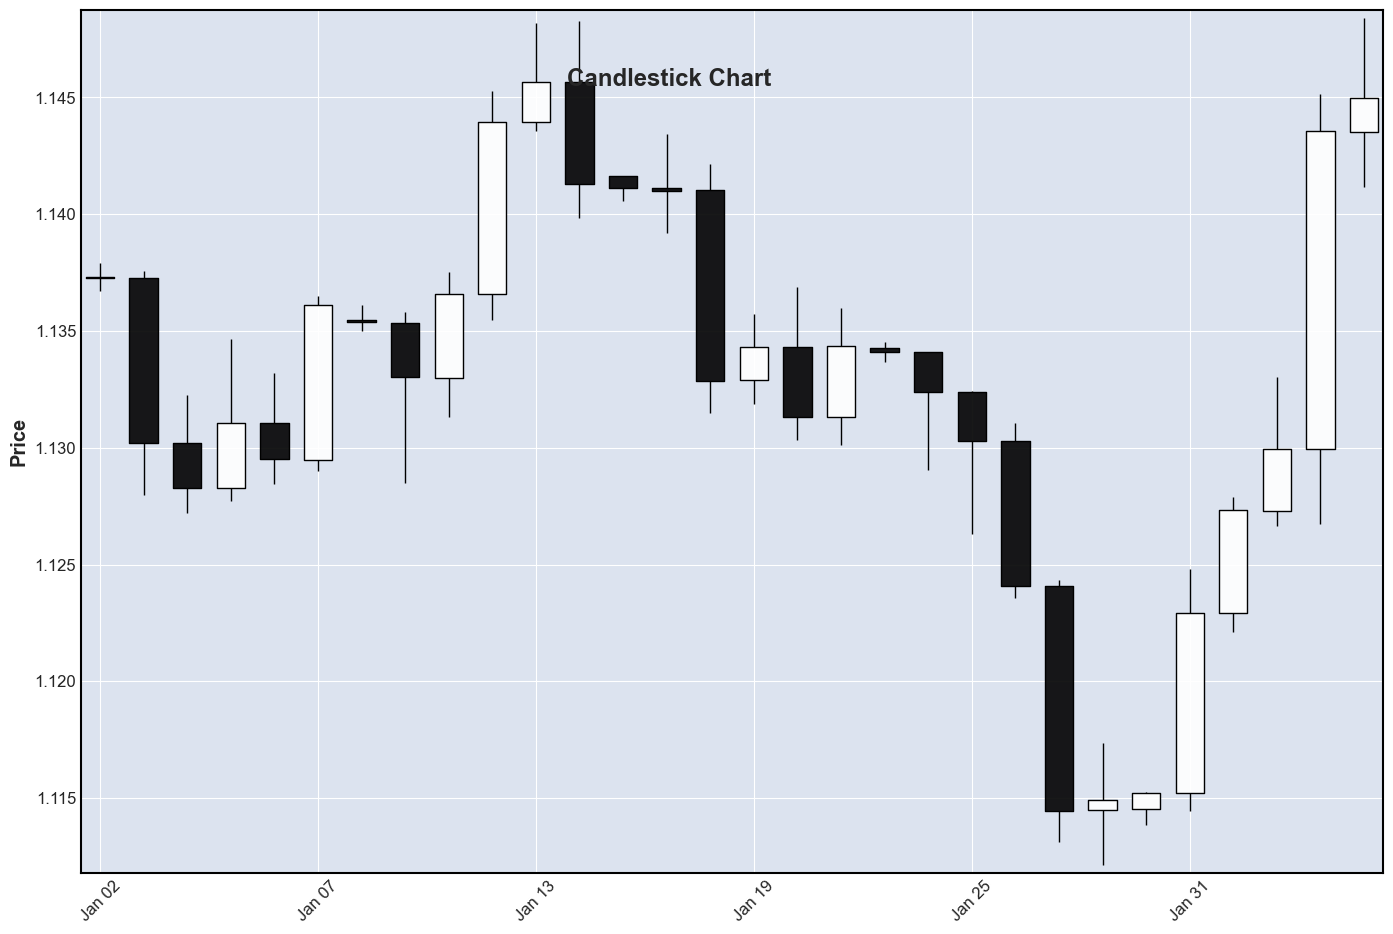

In [11]:
plot_data(ohlc)

In [12]:
df,ohlc = get_candlestick_data_optimised('1 Jan 2022','1 Jan 2023','1D','ticks_2022.pkl','ohlc_1D_2022.pkl')

01 Jan 2022 01 Feb 2022
2023-09-08 09:30:47,669 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2023-09-08 09:30:47,670 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for EURUSD
2023-09-08 09:30:47,677 - findatapy.market.datavendorweb - INFO - Downloading... 2022-01-01 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2022/00/01/00h_ticks.bi5
2023-09-08 09:30:52,308 - findatapy.market.datavendorweb - INFO - Downloading... 2022-01-02 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2022/00/02/00h_ticks.bi5
2023-09-08 09:30:57,344 - findatapy.market.datavendorweb - INFO - Downloading... 2022-01-03 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2022/00/03/00h_ticks.bi5
2023-09-08 09:31:02,476 - findatapy.market.datavendorweb - INFO - Downloading... 2022-01-04 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2022/00/04/00h_ticks.bi5
2023-09-08 09:31:07,643 - findatapy.market.datavendorweb - INFO - Downloading... 2022-01-05 00:00:00 h

In [14]:
# shift data from outside to inside
years = ['2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022']
for i,year in enumerate(years):
    df = pd.read_pickle('Data for Practicum 2/ticks_'+year+'.pkl')
    print(df.columns)
    df.rename(columns={'EURUSD.mid':'mid'},inplace=True)
    df.to_pickle('Data for Practicum 2/EURUSD/ticks_'+year+'.pkl')

Index(['EURUSD.bid', 'EURUSD.ask', 'EURUSD.mid'], dtype='object')
Index(['EURUSD.bid', 'EURUSD.ask', 'EURUSD.mid'], dtype='object')
Index(['EURUSD.bid', 'EURUSD.ask', 'EURUSD.mid'], dtype='object')
Index(['EURUSD.bid', 'EURUSD.ask', 'EURUSD.mid'], dtype='object')
Index(['EURUSD.bid', 'EURUSD.ask', 'EURUSD.mid'], dtype='object')
Index(['EURUSD.bid', 'EURUSD.ask', 'EURUSD.mid'], dtype='object')
Index(['EURUSD.bid', 'EURUSD.ask', 'EURUSD.mid'], dtype='object')
Index(['EURUSD.bid', 'EURUSD.ask', 'EURUSD.mid'], dtype='object')
Index(['EURUSD.bid', 'EURUSD.ask', 'EURUSD.mid'], dtype='object')
Index(['EURUSD.bid', 'EURUSD.ask', 'EURUSD.mid'], dtype='object')
Index(['EURUSD.bid', 'EURUSD.ask', 'EURUSD.mid'], dtype='object')
Index(['EURUSD.bid', 'EURUSD.ask', 'EURUSD.mid'], dtype='object')
